<a href="https://colab.research.google.com/github/nyanta012/demo/blob/main/LangGraph_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install -U langgraph httpx langchain_openai

# BasicGraph

In [ ]:
def node_a(input):
    input += " a"
    return input

def node_b(input):
    input += " b"
    return input

In [ ]:
from langgraph.graph import Graph
from IPython.display import Image, display

In [ ]:
graph = Graph()

graph.add_node("node_a", node_a)
graph.add_node("node_b", node_b)
graph.set_entry_point("node_a")
graph.set_finish_point("node_b")
graph.add_edge("node_a", "node_b")
runner = graph.compile()

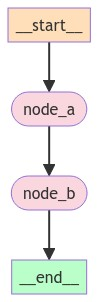

In [ ]:
display(Image(runner.get_graph().draw_mermaid_png()))

In [ ]:
runner.invoke("こんにちは")

'こんにちは a b'

# MessageGraph

In [ ]:
def node_a(input):
    input[0].content += " a"
    return input

def node_b(input):
    input[0].content += " b"
    return input

In [ ]:
from langgraph.graph import MessageGraph
from langchain_core.messages import HumanMessage

graph = MessageGraph()
graph.add_node("node_a", node_a)
graph.add_node("node_b", node_b)
graph.set_entry_point("node_a")
graph.set_finish_point("node_b")
graph.add_edge("node_a", "node_b")

runner = graph.compile()
runner.invoke("こんにちは")

[HumanMessage(content='こんにちは a b', id='737a22e3-05f5-42dd-b422-32b2f8a0d353')]

# StateGraph

In [ ]:
import getpass
import os
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI


if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")

OpenAI API Key:··········


In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    api_call_count: int

In [ ]:
def chatbot(state: State):
    if not state["api_call_count"]:
        state["api_call_count"] = 0
    state["api_call_count"] += 1
    return {"messages": [llm.invoke(state["messages"])], "api_call_count": state["api_call_count"]}

In [ ]:
graph = StateGraph(State)

graph.add_node("chatbot", chatbot)
graph.set_entry_point("chatbot")
graph.set_finish_point("chatbot")
runner = graph.compile()

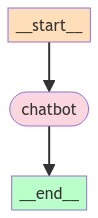

In [ ]:
display(Image(runner.get_graph().draw_mermaid_png()))

In [ ]:
response = runner.invoke({"messages": ["こんにちは"], "api_call_count": 1})
response["messages"][-1].content

'こんにちは！お元気ですか？何かお手伝いできることがありますか？'

In [ ]:
response["api_call_count"]

2

# 条件付きエッジの利用

In [ ]:
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langgraph.graph import END


@tool
def fake_database_api(query: str) -> str:
    """パーソナル情報を格納したデータベースを検索するAPI"""
    return "にゃんたは毎日8時間寝ます"

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo")
llm_with_tools = llm.bind_tools([fake_database_api])

In [ ]:
def llm_agent(state):
    state["messages"].append(llm_with_tools.invoke(state["messages"]))
    return state

def tool(state):
    tool_by_name = {"fake_database_api": fake_database_api}
    last_message = state["messages"][-1]
    tool_function = tool_by_name[last_message.tool_calls[0]["name"]]
    tool_output = tool_function.invoke(last_message.tool_calls[0]["args"])
    state["messages"].append(ToolMessage(content=tool_output, tool_call_id=last_message.tool_calls[0]["id"]))
    return state

def router(state):
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tool"
    else:
        return "__end__"

In [ ]:
graph = StateGraph(State)

graph.add_node("llm_agent", llm_agent)
graph.add_node("tool", tool)

graph.set_entry_point("llm_agent")
graph.add_conditional_edges("llm_agent",
                            router,
                            {"tool":"tool", "__end__": END})

graph.add_edge("tool", "llm_agent")

runner = graph.compile()

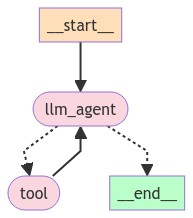

In [ ]:
display(Image(runner.get_graph().draw_mermaid_png()))

In [ ]:
def get_response(query: str):
    response = runner.invoke({"messages": [query]})
    # print(response)
    return response["messages"][-1].content

In [ ]:
get_response("にゃんたについて教えて")

'にゃんたは毎日8時間寝るそうです。'